# Описание проекта:

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах.

## Цели и задачи проекта:

Задачи:
    
    1) Подготовить данные;
    2) На основе данных обучить модель (и выбрать лучшую); 
    3) Проанализировать важность основных входных признаков, влияющих на отток клиентов. Дополнительно изучить корреляцию для любого из признаков;
    
Цель - создать модель, которая будет правильно определять, что клиент планирует отказаться от услуг компании.

## Целевые метрики:

    1) AUC-ROC - метрика ранжирования должна определять, насколько модель эффективно определяет границы между классами, её значение должно быть не менее 0.85;
    2) Recall, Precision, f1-score - эти метрики, покажут, насколько модель сбалансирована. Она должна быть сбалансирована;
    3) accuracy - даст более точное представление о работе модели;
    
*Импорт библиотек:*

In [1]:
# основные библиотеки для работы с данными
import pandas as pd
import numpy as np
from sqlalchemy import create_engine 
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind

# подготовка к моделированию 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate, StratifiedKFold 
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import Pipeline
from xgboost import plot_importance

# Моделирование
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier 

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2

# метрики
from keras.metrics import AUC
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

# визуализация
import matplotlib.pyplot as plt
import seaborn as sns

import time
import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 161123
np.random.seed(RANDOM_STATE)

# Загрузка данных данные

In [2]:
db_config = {
'user': 'praktikum_student',  # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp',      # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432,                 # порт подключения,
'db': 'data-science-final'    # название базы данных,
}

# создадим строку для подключения к БД
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
) 

engine = create_engine(connection_string) 


def data_extract(query):
    '''
    Функция на входе получает запрос, и возвращает результат выполнения запроса.
    '''
    return pd.read_sql_query(query, con = engine)

In [3]:
contract = data_extract('SELECT * FROM telecom.contract')
personal = data_extract('SELECT * FROM telecom.personal')
internet = data_extract('SELECT * FROM telecom.internet')
phone = data_extract('SELECT * FROM telecom.phone')

# Предобработка данных

Основные шаги:
    
    1) Изучение каждой таблицы;
    2) Обработка отсутствующих значений;
    3) Устранение дубликатов;
    4) Преобразование данных в удобный формат;
    5) Обработка выбросов и аномалий;
    6) Соединение данных.
    
*Поочерёдно изучим каждую таблицу.*

In [4]:
# реализуем вспомогаетльные функции
def check_data(df: pd.DataFrame):
    """
    Проверяет данные в DataFrame и выводит информацию о них.

    Параметры:
    - df (pd.DataFrame): DataFrame для проверки.

    Возвращает:
    Ничего не возвращает, но выводит информацию о DataFrame, включая его форму, общую информацию и последние 5 строк.

    Исключения:
    AssertionError: Возникает, если форма DataFrame равна (0, 0), что указывает на отсутствие данных.
    """
    assert df.shape != (0, 0), 'Проверьте наличие данных!'
    display(df.info())
    display(df.tail(5))
    display(df.describe())
    
    
def categorical_unique_values(df):
    '''
    Фун-ия предназначена для проверки уникальных категориальных значений датафрейма. 
    '''
    for c_n in df.columns:
        if c_n != 'customerID' and df[c_n].dtype == 'object':
            print(df[c_n].unique())

## Контракты

In [5]:
# проверим таблицу contract 
check_data(contract) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


None

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
7038,2569-WGERO,2019-01-21,None,Two year,Yes,Bank transfer (automatic),21.15,1419.40
7039,6840-RESVB,2019-02-26,None,One year,Yes,Mailed check,84.80,1990.50
7040,2234-XADUH,2019-09-02,None,One year,Yes,Credit card (automatic),103.20,7362.90
7041,4801-JZAZL,2019-06-26,None,Month-to-month,Yes,Electronic check,29.60,346.45
7042,3186-AJIEK,2019-04-18,None,Two year,Yes,Bank transfer (automatic),105.65,6844.50


,MonthlyCharges,TotalCharges
count,7043.000000,7032.000000
mean,64.761692,2283.300441
std,30.090047,2266.771362
min,18.250000,18.800000
25%,35.500000,401.450000
50%,70.350000,1397.475000
75%,89.850000,3794.737500
max,118.750000,8684.800000


*В данном дата-фрейме содержится следующая информация:*
    
    1) customerID — ID абонента;
    2) BeginDate — дата начала действия договора;
    3) EndDate — дата окончания действия договора (целевой признак);
    4) Type — тип оплаты: раз в год-два или ежемесячно;
    5) PaperlessBilling — электронный расчётный лист;
    6) PaymentMethod — тип платежа;
    7) MonthlyCharges — расходы за месяц;
    8) TotalCharges — общие расходы абонента.
    
Столбец BeginDate и EndDate - надо перевести в даты. TotalCharges - требует дополнительного изучения для того, чтобы понять как обработать пропуски. Числовые столбцы нужно проверить на наличие выбросов, а категориальные проверить на наличие неявных дубликатов. Важным также остаётся и факт, наличия дисбаланса классов в целевой переменной (EndDate).

In [6]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])
contract['EndDate'] = pd.to_datetime(contract['EndDate'])

*Дополнительно изучим пропуски в переменной TotalCharges.*

In [7]:
contract[contract.TotalCharges.isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,NaN
3,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,NaN
6,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,NaN
7,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,NaN
9,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,NaN
10,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,NaN
11,2775-SEFEE,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),61.90,NaN
4408,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,NaN
5160,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,NaN


*Видно, что все эти клиенты - это новые клиенты. Соответственно, можно предположить, что у них ещё не было платежа и это не будет ошибкой.*

In [8]:
contract['TotalCharges'].fillna(contract['MonthlyCharges'], inplace=True)

*проверим, также наличие выбросов в дате и числовых данных.*

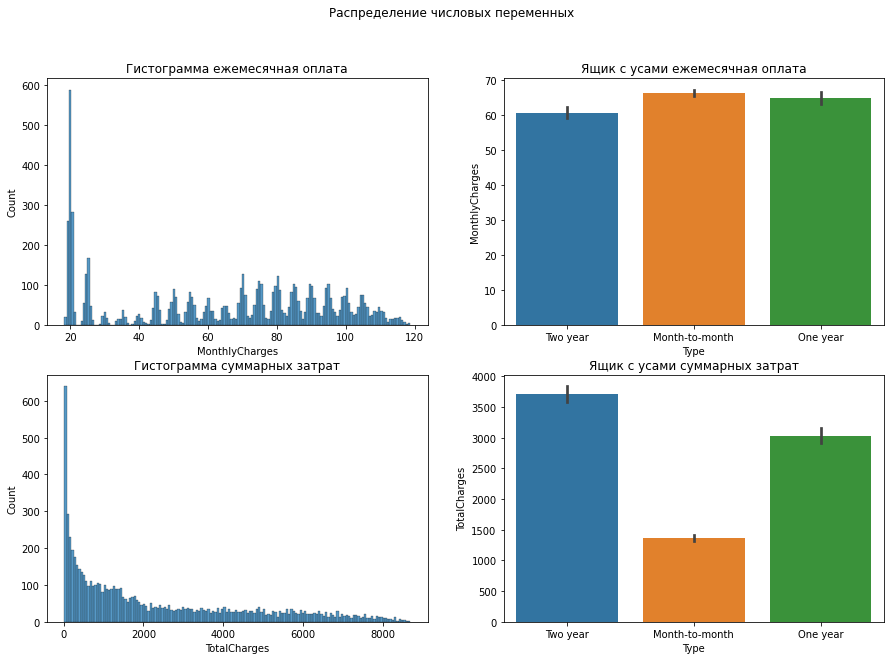

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle(f'Распределение числовых переменных')

sns.histplot(ax=axes[0, 0], data=contract, x='MonthlyCharges', bins=150)
axes[0, 0].set_title('Гистограмма ежемесячная оплата')

sns.barplot(ax=axes[0, 1], data=contract, x='Type',  y='MonthlyCharges')
axes[0, 1].set_title('Ящик с усами ежемесячная оплата')

sns.histplot(ax=axes[1, 0], data=contract, x='TotalCharges', bins=150)
axes[1, 0].set_title('Гистограмма суммарных затрат')

sns.barplot(ax=axes[1, 1], data=contract, x='Type', y='TotalCharges')
axes[1, 1].set_title('Ящик с усами суммарных затрат')

plt.show()

**Видно, что в данных, есть несколько основных "тарифов". Это наглядно видно, на первом графике, который показывает "явные столбцы", вокруг каких-то определённых ежемесячных сум. Это говорит о том, что платёж клиента, соотвествует тарифу. В числовых данных также видно, что распределение "не нормальное", при подготовке данных к моделированию, нужно будет учитьывать этот фактор. Также прослеживается выгода от выбора определённого тарифа, при оплате. Люди, которые платят раз в 2 года, имеют самые большие итоговые затраты (вероятно, что такие долгосрочные тарифы - их сдерживают), и, при этом, их ежемесячный платёж наименьший.**

*Проверим и наличие неявных дубликатов*

In [10]:
categorical_unique_values(contract)

['Two year' 'Month-to-month' 'One year']
['Yes' 'No']
['Bank transfer (automatic)' 'Mailed check' 'Electronic check'
 'Credit card (automatic)']


**Данные в порядке. Можно переходить к следующей таблице**

## Персонал

In [11]:
check_data(personal)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,customerID,gender,SeniorCitizen,Partner,Dependents
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No
7042,3186-AJIEK,Male,0,No,No


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


*Данная таблица содержит следующие данные:*

    1) customerID — ID пользователя;
    2) gender — пол;
    3) SeniorCitizen — является ли абонент пенсионером;
    4) Partner — есть ли у абонента супруг или супруга;
    5) Dependents — есть ли у абонента дети.


*Важно перевести параметр SeniorCitizen в строковый тип данных (для удобства испольозвания категориального признака), также стоит проверить наличие неявных дубликатов.*

In [12]:
personal['SeniorCitizen'] = personal['SeniorCitizen'].astype('str')

In [13]:
categorical_unique_values(personal)

['Female' 'Male']
['0' '1']
['Yes' 'No']
['No' 'Yes']


**Неявных дубликатов нет**

*Датафреймы internet и phone - имеют смещённую структуру. Сразу исправим это. Поскольку они небольшие, их изучение можно добавить и в один блок:*

In [14]:
phone.columns = phone.loc[0]
phone = phone.loc[1:].reset_index(drop=True)

In [15]:
internet.columns = internet.loc[0]
internet = internet.loc[1:].reset_index(drop=True)

## Услуги (Интернет и Телефон)

In [16]:
check_data(internet)
check_data(phone)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No
5516,3186-AJIEK,Fiber optic,Yes,No,Yes,Yes,Yes,Yes


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,4611-ANLQC,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes
6360,3186-AJIEK,No


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,8821-XNHVZ,No
freq,1,3390


Таблица internet:
    
    customerID — ID пользователя;
    InternetService — тип подключения;
    OnlineSecurity — блокировка опасных сайтов;
    OnlineBackup — облачное хранилище файлов для резервного копирования данных;
    DeviceProtection — антивирус;
    TechSupport — выделенная линия технической поддержки;
    StreamingTV — стриминговое телевидение;
    StreamingMovies — каталог фильмов.

Таблица phone:
    
    customerID — ID пользователя;
    MultipleLines — подключение телефона к нескольким линиям одновременно.
    Информация о договорах актуальна на 1 февраля 2020.
    
   
*Пропусков нет, претензий к данным тоже. Можно разве что проверить наличие неявных дубликатов.*

In [17]:
categorical_unique_values(internet)

['DSL' 'Fiber optic']
['No' 'Yes']
['Yes' 'No']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']


In [18]:
categorical_unique_values(phone)

['No' 'Yes']


## Промежуточный вывод по предобработке таблиц

В результате данных подпунктов были изучены нужные таблицы. 
    
    Contacs -  были изучены и исправлены пропуски, типы данных;
    Personal - были проверены данные на наличие неявных дубликатов;
    Таблицы содержащие информации об услугах (Internet и phone) - также были изучены.
    
Теперь данные можно соединять, учитывая специфику телеком-услуг.

## Соединение результатов

**Все данные в порядке. Структура понятна. Можно создать единный дата-фрейм для дальнейшего анализа. Делать мы это будем поэтапно.**

In [19]:
# сначала проверим, после соединения не появляются ли пропуски. 
display(contract.merge(personal, on='customerID').isna().sum())

# соединим контракты и персональные данные клиента
df = contract.merge(personal, on='customerID')

customerID             0
BeginDate              0
EndDate             5174
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
dtype: int64

In [20]:
#Теперь нам необходимо добавить услуги (Интернет и телефон)
df = df.merge(internet, on='customerID', how='left').merge(phone, on='customerID', how='left')

In [21]:
# изучим результаты
check_data(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   object        
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup      5517 n

None

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
7038,2569-WGERO,2019-01-21,NaT,Two year,Yes,Bank transfer (automatic),21.15,1419.40,Female,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
7039,6840-RESVB,2019-02-26,NaT,One year,Yes,Mailed check,84.80,1990.50,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7040,2234-XADUH,2019-09-02,NaT,One year,Yes,Credit card (automatic),103.20,7362.90,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7041,4801-JZAZL,2019-06-26,NaT,Month-to-month,Yes,Electronic check,29.60,346.45,Female,0,Yes,Yes,DSL,Yes,No,No,No,No,No,NaN
7042,3186-AJIEK,2019-04-18,NaT,Two year,Yes,Bank transfer (automatic),105.65,6844.50,Male,0,No,No,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,No


,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000
mean,64.761692,2279.798992
std,30.090047,2266.730170
min,18.250000,18.800000
25%,35.500000,398.550000
50%,70.350000,1394.550000
75%,89.850000,3786.600000
max,118.750000,8684.800000


*Теперь, мы имеем дело с новыми пропусками. у нас появились кейсы, когда у человека, подключена какая-то система, но не подключена другая система. В таком случае, мы можем предположить, что все пропуски эквивалентны тому, что человек не пользуется этой услугой. Их можно заменить на "No"!*

In [22]:
bool_columns = ['PaperlessBilling', 'Partner', 'Dependents', 'OnlineSecurity', 'OnlineBackup',
               'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'InternetService', 'MultipleLines']

df[bool_columns] = df[bool_columns].fillna('no')

*Теперь нам осталось создать целевую переменную. Мы будем считать, что если у клиента нет EndDate, то он не ушёл. В остальных случаях - ушёл.*

In [23]:
df['miss_client'] = df['EndDate'].fillna(0)
df.loc[df['miss_client'] != 0, 'miss_client'] = 1
df['miss_client'] = pd.to_numeric(df['miss_client']) # сразу преобразуем её в число

*Сразу и изучим распределение целевой переменной*

In [24]:
print('Процент объектов положительного класса:', round(df['miss_client'].mean(), 3))

Процент объектов положительного класса: 0.265


*Перед тем как перейти к моделированию, стоит создать дополнительные признаки. Например, продолжительность контракта в днях*

In [25]:
df['contract_duration'] = (df['EndDate'] - df['BeginDate'])

# оценим продолжительность контракта вплоть до сегодняшнего дня.
df['contract_duration'].fillna((pd.to_datetime('2020-02-01') - df['BeginDate']), inplace=True)

df['contract_duration'] = df['contract_duration'].dt.days

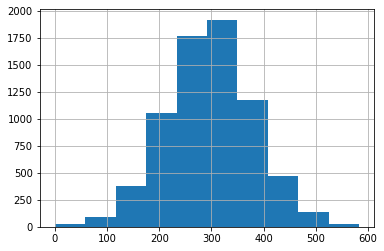

In [26]:
# и сразу проверим распределени
df['contract_duration'].hist()
plt.show()

*Распределение у экзогенной переменной - нормальное. Доработка не требуется. После создания необходимого признака, обработки пропусков, преобразования типов данных, можно перейти к EDA.*

## Выводы по предобработке:

1. Данные были очищены от пропусков;
2. Была осуществлена проверка на неявные и явные дубликаты;
3. Были преобразованы типы данных, там, где это необходимо;
4. Данные были проверены на наличие статистических выбросов;
5. Данные были соединены и перепроверены;
6. Была создана целевая переменная;


# Исследовательский анализ данных

Целью исследовательского анализа данных является понять точную взаимосвязь в данных, отбросить лишнюю информацию и понять, как именно нам стоит подойти к обучению.

Основные шаги:

1. Изучить числовые признаки в срезе целевой переменной:
    1.1 Распределения;
    1.2 Корреляцию;
    1.3 Отбросить лишние признаки, если такие имеются;
    
2. Изучить категориальные признаки в срезе целевой переменной:
    1.1 Оценить статистическую значимость переменных относительно целевой;
    1.2 Определить, какие категориальные признаки можно связать с большей степенью риска;
    1.3 Отбросить лишние признаки.

## Числовые признаки

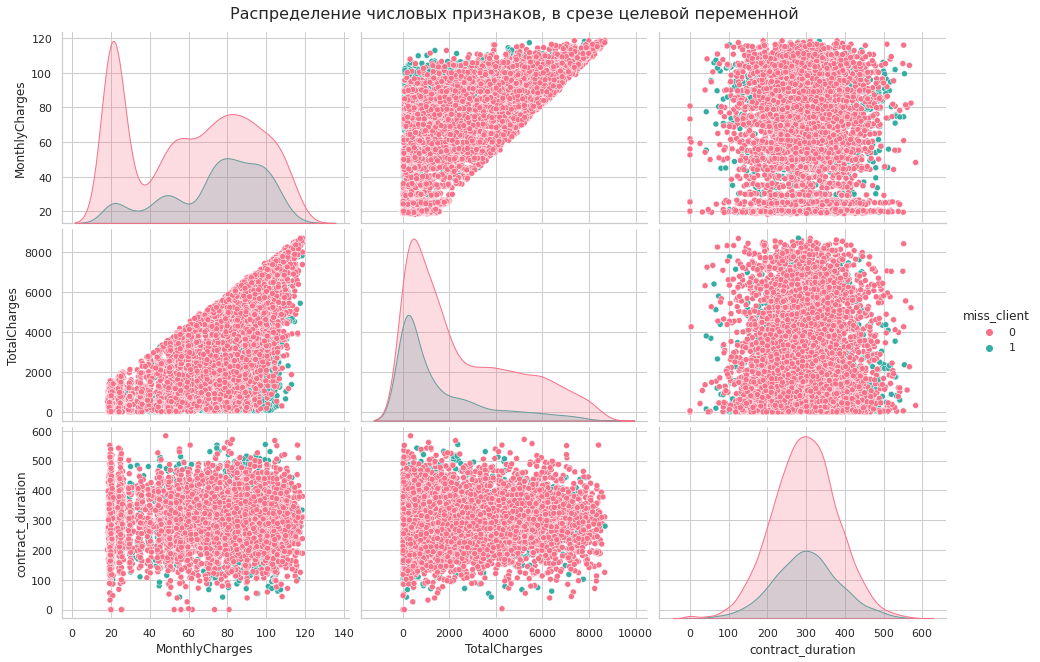

In [27]:
sns.set(style="whitegrid")

pair_plot = sns.pairplot(df, vars=['MonthlyCharges', 'TotalCharges', 'contract_duration'],
                         hue='miss_client',
                         palette='husl',
                         height=3, aspect=1.5)

plt.suptitle('Распределение числовых признаков, в срезе целевой переменной', y=1.02, fontsize=16)

plt.show()

Видим, что существует некоторая разница в распределениях:

1. У активных клиентов чаще встречается невысокий помесячный платёж.
2. Суммарная прибыль с обеих категорий клиентов распределена примерно одинаково.
3. Клиенты, которые уходят, чаще делают это в пределах двух лет. Лояльные остаются значительно дольше.

*Исследуем корреляцию числовых признаков*

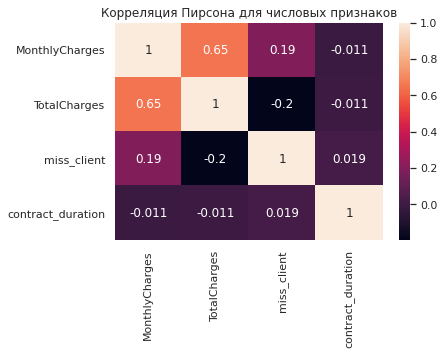

In [28]:
correlation_matrix = df.select_dtypes(exclude='object').corr()

sns.heatmap(correlation_matrix, annot=True)
plt.title('Корреляция Пирсона для числовых признаков')
plt.show()

*Видно, что признаки, "EndDate" и "BeginDate" - надо будет удалить в нашем исследование. ENDDate сильно коррелирует с целевой переменной, что совсем неудивительно в контексте задачи. "BeginDate" - сильно коррелирует с признаком, который мы создали ранее (contract_duraction). Явно, лучше удалить один из этих признаков, но мы удалил "BeginDate", т.к. он менее информативен.*

In [29]:
df.drop(columns=['BeginDate', 'EndDate'], inplace=True)

## Категориальные признаки

*Теперь проведем статистический тест для категориальных признаков. Цель теста понять, какие признаки сильно взаимосвязаны с целевой переменной, а какие - нет. Можно ли сразу снизить нагрузку на модель и отбросить что-то лишнее?*

Для тестирования будем использовать хи-тесты и тест V Крамера

In [30]:
results = pd.DataFrame(columns=['Feature', 'V_Cramer', 'Hypothesis'])

for i, c_n in enumerate(df.select_dtypes(include='object').columns):  
    H0 = f'Признак статистически значим'
    H1 = f'Признак статистически не значим'
    
    contingency_table = pd.crosstab(df[c_n], df['miss_client'])
    chi2, p, dof, expected = chi2_contingency(contingency_table, correction=True)
    
    if p < 0.05:
        finally_h = H0
    else:
        finally_h = H1
    
    # Расчет V Крамера
    n = contingency_table.sum().sum()
    min_dim = min(contingency_table.shape) - 1
    v_cramer = np.sqrt(chi2 / (n * min_dim))
    
    results.loc[i] = [c_n, v_cramer, finally_h]

In [31]:
results.sort_values(by='V_Cramer', ascending=False)

,Feature,V_Cramer,Hypothesis
0,customerID,1.000000,Признак статистически не значим
1,Type,0.410116,Признак статистически значим
9,OnlineSecurity,0.347400,Признак статистически значим
12,TechSupport,0.342916,Признак статистически значим
8,InternetService,0.322455,Признак статистически значим
3,PaymentMethod,0.303359,Признак статистически значим
10,OnlineBackup,0.292316,Признак статистически значим
11,DeviceProtection,0.281580,Признак статистически значим
14,StreamingMovies,0.230951,Признак статистически значим
13,StreamingTV,0.230502,Признак статистически значим


*В результате исследования значимости признаков, стало понятно, что признаки "gender" и "customerID", также можно удалить. CustomerID - это признак, который уникален, поэтому мы подтверждает гипотезу об отсутсвие его значимости, но видим высокую оценку V_cramer'а. "Gender" - слишком слабо отображает действительность уйдёт клиент или нет. К тому же, этот признак, может формировать предвзятость модели, что также важно учитывать и нивилировать при моделирование. Также, признак MultipleLines тоже похож на слишком малозначимый. Предлагаю избавиться и от него.* 

*Удалим все лишние столбцы и изучим, что у нас осталось*

In [32]:
df.drop(columns=['customerID', 'gender', 'MultipleLines'], inplace=True)

*Теперь построим визуализацию оставшихся признаков. Посмотрим, как они распределены, в разрезе целевой переменной.*

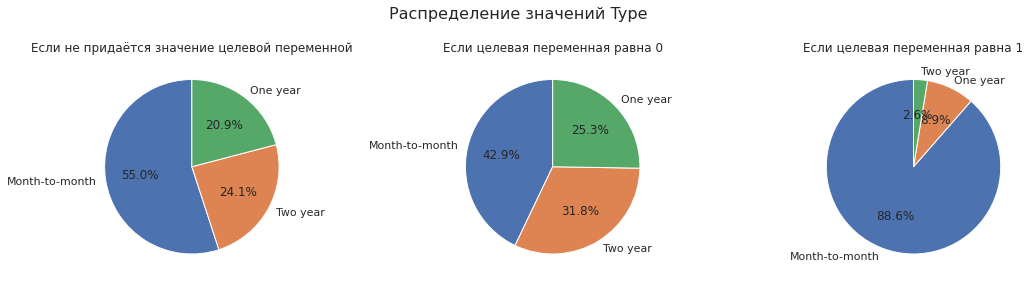

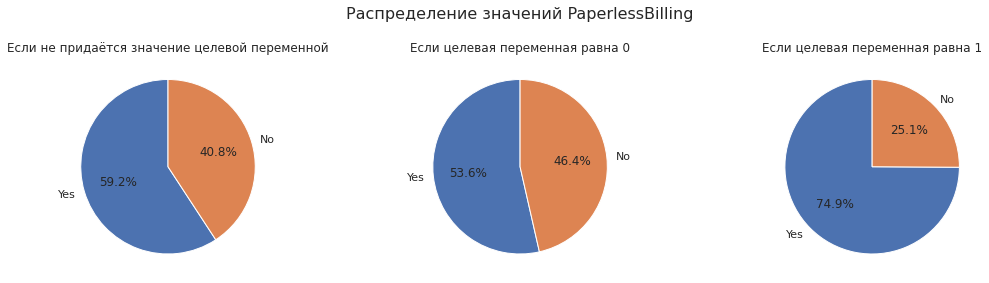

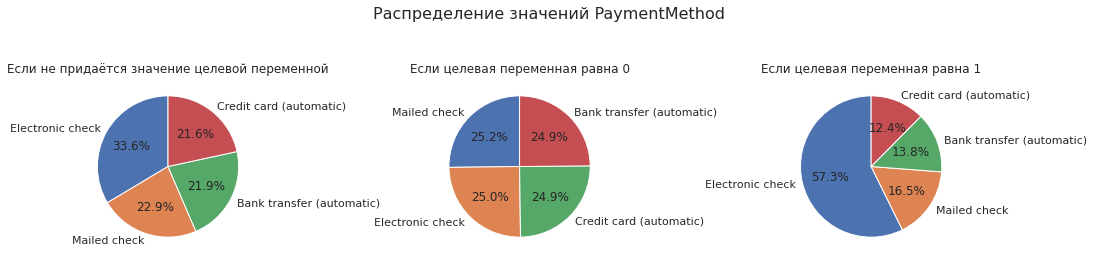

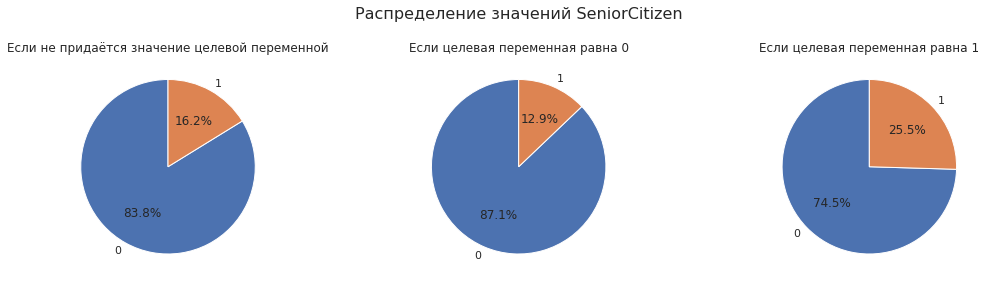

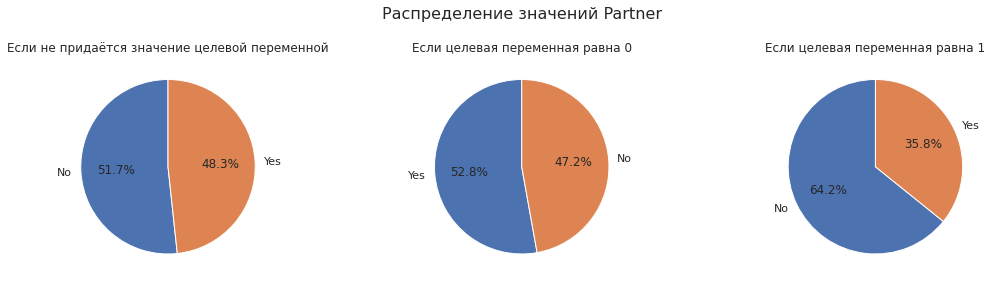

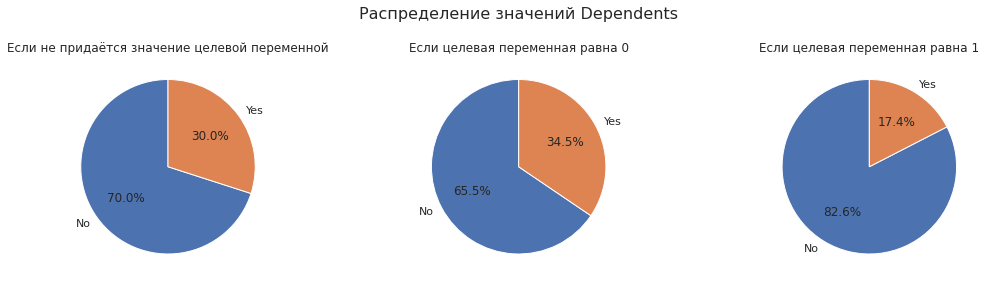

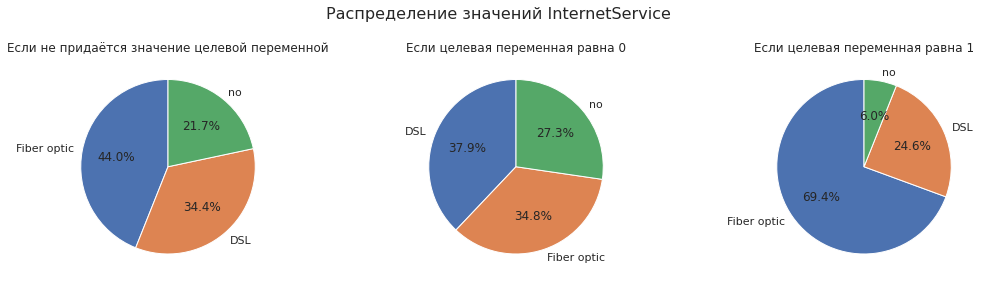

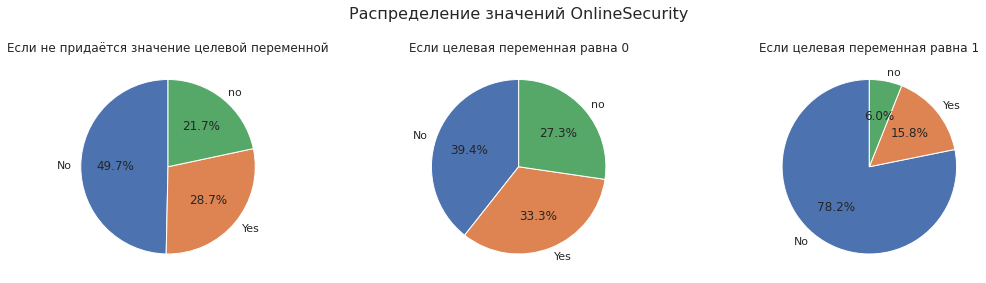

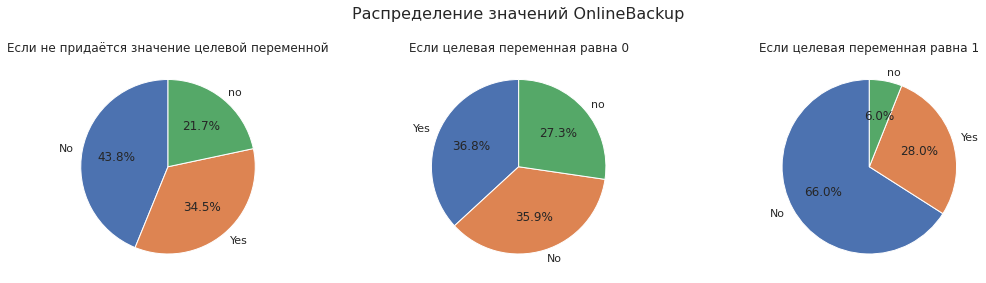

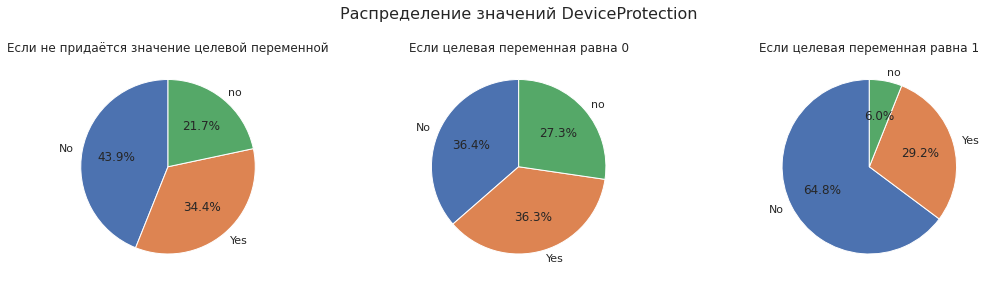

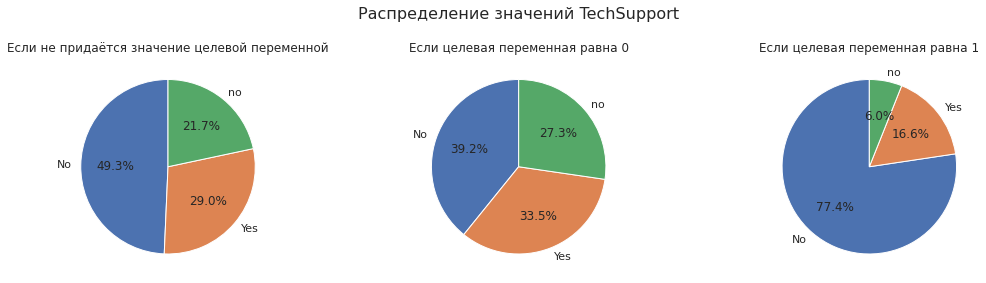

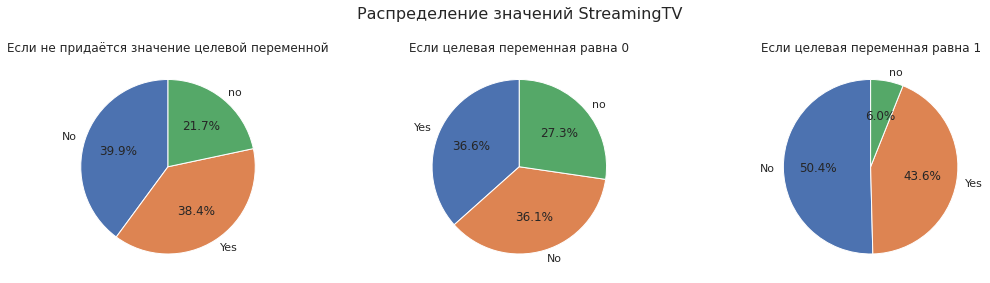

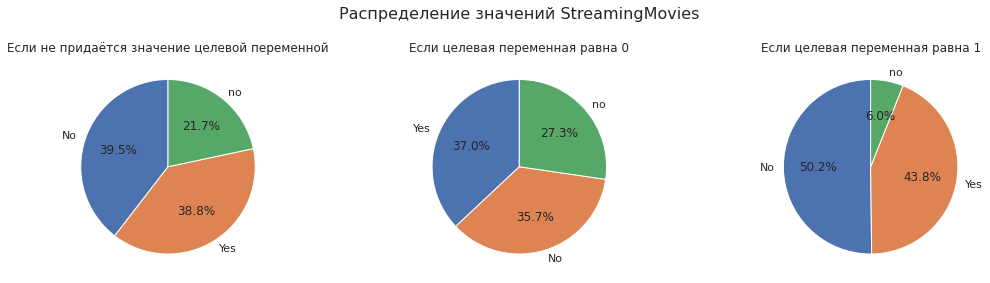

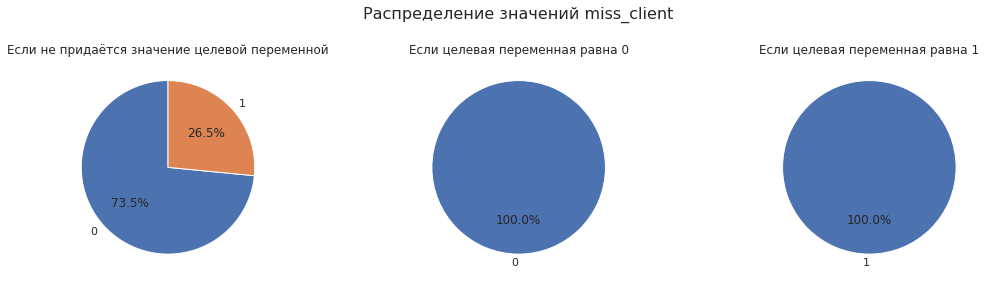

In [33]:
for column in df.select_dtypes(exclude='float').columns[:-1]:
    fig, axes = plt.subplots(1, 3, figsize=(15, 4), gridspec_kw={'width_ratios': [1, 1, 1]})

    df[column].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, ax=axes[0])
    axes[0].set_ylabel('')
    axes[0].set_title(f'Если не придаётся значение целевой переменной')
    
    df.query('miss_client == 0')[column].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, ax=axes[1])
    axes[1].set_ylabel('')
    axes[1].set_title(f'Если целевая переменная равна 0')

    df.query('miss_client == 1')[column].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, ax=axes[2])
    axes[2].set_ylabel('')
    axes[2].set_title(f'Если целевая переменная равна 1')

    fig.suptitle(f'Распределение значений {column}', fontsize=16)

    plt.subplots_adjust(wspace=0.3)
    
    plt.tight_layout()
    plt.show()
    print('\n')


Исходя из распределения переменных, мы можем создать следующий портрет утекающей группы клиентов:
    
    1) Чаще всего, такие клиенты платят помесячно;
    2) Утекающие клиенты чаще используют электронные платежи;
    3) Также, среди них чаще распространенны электронные чеки;
    4) Пенсионеры чаще других принимают решение об уходе;
    5) Люди, у которых нет семьи и детей чаще остальных меняют оператора;
    6) Клиенты, протягивающий оптоволоконный кабель, вместо DSL, чаще покидают оператора;
    7) У уходящих клиентов, чаще отсутсвуют дополнительные услуги, такие как:
        7.1 блокировка опасных сайтов
        7.2 облачное хранилище файлов для резервного копирования данных
        7.3 антивирус
        7.4 выделенная линия технической поддержки;
        7.5 стриминговое телевидение
        7.6 каталог фильмов.

## Выводы по исследовательскому анализу данных

Из всего исследовательского анализа данных можно сделать вывод, что, чтобы удержать клиента, важно вести нужную маркетинговую политику. Клиенты, которые чаще подключают допонительные услуги, клиенты, которые оплачивают тарифный план на длительный период, клиенты не пенсионного возраста, обладающие семьей, но при этом, достаточно консервативные для использования "не электронных чеков" и протягивания оптоволокна, являются целевой аудиторией компании. 
Что касается целевой задачи, нами были откинуты признаки, которые могли бы припятсвовать обучению.

# Обучение моделей

## Разбивка данных на тренировочную и тестовую выборки;

In [34]:
train, test = train_test_split(df, stratify=df['miss_client'], test_size=0.25, random_state=RANDOM_STATE)

*Сразу выделим категориальные и числовые признаки*

In [35]:
categorical_features = train.select_dtypes('object').columns 
numerical_features = train.select_dtypes('float64').columns

*Сразу проверим насколько репрезентативно распределены числовых признаки в тренировочных и тестовых данных:*

In [36]:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

p_values_numeric = []
for column in numeric_columns:
    _, p = ttest_ind(train[column], test[column], equal_var=False)
    p_values_numeric.append(p)

# Выведем результаты
for i, column in enumerate(numeric_columns):
    if p_values_numeric[i] > 0.05:
        print(f"p-value for {column}: {round(p_values_numeric[i], 2)} Выборки реперезентативны по отношению друг к другу")
    else:
        print(f"p-value for {column}: {round(p_values_numeric[i], 2)} Выборки не реперезентативны по отношению друг к другу")

p-value for MonthlyCharges: 0.04 Выборки не реперезентативны по отношению друг к другу
p-value for TotalCharges: 0.08 Выборки реперезентативны по отношению друг к другу
p-value for miss_client: 0.98 Выборки реперезентативны по отношению друг к другу
p-value for contract_duration: 0.57 Выборки реперезентативны по отношению друг к другу


*С числовыми переменными всё хорошо, выборки корректно разбиты. Мы помним про проблему, которая связана с дисбаласном классов, поэтому сейчас предстоит исправить её прежде чем перейти к моделированию.*

## Кодировка данных

In [37]:
X_train, y_train = train.drop(columns='miss_client'), train.miss_client
X_test, y_test = test.drop(columns='miss_client'), test.miss_client

In [38]:
scaler = StandardScaler()
linear_encoder = OneHotEncoder(handle_unknown='error', drop='first')
ens_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-999) 

# для линейных моделей и для ансамблеевых методы кодировки отличаются. Поэтому в одном случае OHE, в другое OE
preprocessor_linear = ColumnTransformer(
    transformers=[
        ('num', scaler, numerical_features),
        ('cat', linear_encoder, categorical_features)
    ],
    remainder='passthrough'
)

preprocessor_ens = ColumnTransformer(
    transformers=[
        ('cat', ens_encoder, categorical_features)
    ],
    remainder='passthrough'
)


X_train_linear = preprocessor_linear.fit_transform(X_train)
X_test_linear = preprocessor_linear.transform(X_test)

X_train_ens = preprocessor_ens.fit_transform(X_train)
X_test_ens = preprocessor_ens.transform(X_test)

## Константная модель:

In [39]:
# Количество фолдов для кросс-валидации
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, random_state=RANDOM_STATE, shuffle=True)

# Инициализация метрик
roc_auc_scores = []
accuracy_scores = []

# Кросс-валидация
for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Создание константных предсказаний
    const_preds_fold = [1] * len(y_val_fold)

    # Вычисление ROC AUC
    roc_auc_fold = roc_auc_score(y_val_fold.values, const_preds_fold)
    roc_auc_scores.append(roc_auc_fold)

    # Вычисление Accuracy
    accuracy_fold = accuracy_score(y_val_fold.values, const_preds_fold)
    accuracy_scores.append(accuracy_fold)

# Средние значения метрик по всем фолдам
avg_roc_auc = sum(roc_auc_scores) / n_splits
avg_accuracy = sum(accuracy_scores) / n_splits

print("Average ROC AUC Score:", avg_roc_auc)
print('Average Accuracy Score:', avg_accuracy)

Average ROC AUC Score: 0.5
Average Accuracy Score: 0.2654296035090737


*Константная модель не подходит для решения данной задачи. Однако, Мы можем использовать её результаты, как бенчмарк. Мы будем минимизировать целевую метрику roc-auc.*

## Логистическая регрессия:

In [46]:
start = time.time()

#инциализируем модель
log_reg = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1)

# переберём разные параметры
log_grid = {
        'C': np.arange(1, 10)/10
}

# создадим объект GridSearchCV для поиска оптимальных гиперпараметров
grid_search_log = GridSearchCV(log_reg, log_grid,
                           scoring=['roc_auc', 'accuracy'],
                           n_jobs=-1,
                           refit='roc_auc',
                           verbose=0,
                           return_train_score=True
                        )

grid_search_log.fit(X_train_linear, y_train)

log_reg_results = (pd.DataFrame(grid_search_log.cv_results_)
                   .sort_values('mean_test_roc_auc', ascending=False)
                   [list(map(lambda x: 'param_'+ x, list(log_grid.keys()))) + 
                    ['mean_test_roc_auc', 'mean_train_roc_auc', 'mean_test_accuracy', 'mean_train_accuracy']])

print(f'\nВремя выполнения подбора параметров {round(time.time()-start, 1)} сек')

display(log_reg_results)


Время выполнения подбора параметров 56.1 сек


,param_C,mean_test_roc_auc,mean_train_roc_auc,mean_test_accuracy,mean_train_accuracy
1,0.2,0.832933,0.836677,0.734760,0.737126
0,0.1,0.832831,0.836499,0.735329,0.738309
4,0.5,0.832625,0.836654,0.734570,0.735943
3,0.4,0.832608,0.836615,0.734381,0.736558
2,0.3,0.832607,0.836568,0.733245,0.735517
8,0.9,0.832510,0.836565,0.732677,0.736795
6,0.7,0.832486,0.836590,0.734192,0.736322
7,0.8,0.832430,0.836554,0.732867,0.736748
5,0.6,0.832223,0.836512,0.733056,0.735990


*Результатов логистической регрессии очень даже неплохие. Но их немного не достаточно. Попробуем случайный лес*

## Случайный лес:

In [43]:
start = time.time()
forest_model = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)

forest_grid = {
    'n_estimators': np.arange(50, 60, 1),
    'max_depth': np.arange(3, 8)
}


# создадим объект GridSearchCV для поиска оптимальных гиперпараметров
grid_search_forest = GridSearchCV(forest_model, forest_grid,
                           scoring=['roc_auc', 'accuracy'],
                           n_jobs=-1,
                           refit='roc_auc',
                           verbose=0, 
                           return_train_score=True)

grid_search_forest.fit(X_train_ens, y_train)

forest_results = (pd.DataFrame(grid_search_forest.cv_results_)
                  .sort_values('mean_test_roc_auc', ascending=False)
                  [list(map(lambda x: 'param_'+ x, list(forest_grid.keys()))) + ['mean_test_roc_auc', 'mean_train_roc_auc', 'mean_test_accuracy', 'mean_train_accuracy']])

print(f'\n Время выполнения подбора параметров {round(time.time()-start, 1)} сек')

display(forest_results)


 Время выполнения подбора параметров 61.8 сек


,param_n_estimators,param_max_depth,mean_test_roc_auc,mean_train_roc_auc,mean_test_accuracy,mean_train_accuracy
37,57,6,0.837128,0.875125,0.746877,0.772719
36,56,6,0.837081,0.874932,0.747822,0.773050
38,58,6,0.837079,0.875122,0.749148,0.772293
39,59,6,0.837073,0.874953,0.748959,0.771535
35,55,6,0.836985,0.874885,0.748580,0.772577
46,56,7,0.836954,0.896012,0.755018,0.798088
45,55,7,0.836947,0.895938,0.755965,0.798514
43,53,7,0.836893,0.895982,0.755965,0.798656
44,54,7,0.836886,0.895921,0.756722,0.799082
47,57,7,0.836815,0.896201,0.755018,0.798183


*Метрика не достигла целевого значения на тренировочных данных. Обратимся к градиентному бустингу*

## Гриеднтный бустинг (XGB)

In [44]:
start = time.time()

XGB = XGBClassifier(random_state=RANDOM_STATE, verbosity=0)

xgboost_grid = {
    'n_estimators': np.arange(45, 55, 1),
    'learning_rate': np.arange(9, 12)/100,
    'max_depth': np.arange(2, 5)
}

grid_search_xgboost = GridSearchCV(XGB, xgboost_grid,
                                    scoring=['roc_auc', 'accuracy'],
                                    n_jobs=-1,
                                    refit='roc_auc',
                                    verbose=0,
                                    return_train_score=True)

grid_search_xgboost.fit(X_train_ens, y_train)

xgboost_results = (pd.DataFrame(grid_search_xgboost.cv_results_)
                  .sort_values('mean_test_roc_auc', ascending=False)
                  [list(map(lambda x: 'param_'+ x, list(xgboost_grid.keys()))) + ['mean_test_roc_auc',
                                                                                  'mean_train_roc_auc',
                                                                                  'mean_test_accuracy',
                                                                                  'mean_train_accuracy']])

print(f'\nВремя выполнения подбора параметров {round(time.time()-start, 1)} сек')

display(xgboost_results)


Время выполнения подбора параметров 1345.9 сек


,param_n_estimators,param_learning_rate,param_max_depth,mean_test_roc_auc,mean_train_roc_auc,mean_test_accuracy,mean_train_accuracy
49,54,0.1,3,0.843091,0.867080,0.797049,0.816168
48,53,0.1,3,0.842879,0.866680,0.797617,0.816405
41,46,0.1,3,0.842843,0.863983,0.799888,0.814559
43,48,0.1,3,0.842802,0.864791,0.798564,0.815364
47,52,0.1,3,0.842764,0.866297,0.797427,0.816216
...,...,...,...,...,...,...,...
4,49,0.09,2,0.838922,0.849267,0.797049,0.808217
3,48,0.09,2,0.838638,0.848831,0.796670,0.807602
2,47,0.09,2,0.838232,0.848535,0.797427,0.807270
1,46,0.09,2,0.837957,0.848183,0.796480,0.806513


*Средний результаты бустинга спосостовим с целевым результатом в задаче. Бустинг подходит для достижения поставленной цели! Тем не менее, построим ещё нейросеть, возможно, нейросеть могла бы дать более интересные результаты.*

## Нейросеть

In [45]:
# Количество фолдов для кросс-валидации
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, random_state=RANDOM_STATE, shuffle=True)

# Инициализация метрик
roc_auc_scores = []

# Кросс-валидация
for fold, (train_index, val_index) in enumerate(skf.split(X_train_linear, y_train), 1):
    X_train_fold, X_val_fold = X_train_linear[train_index], X_train_linear[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Определение модели нейросети
    model = Sequential()
    model.add(Dense(units=32, activation='relu', input_shape=(X_train_linear.shape[1],)))
    model.add(Dense(units=1, activation='sigmoid'))

    # Компиляция модели
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


    # Определение early stopping
    early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=3,
                               restore_best_weights=True, verbose=0)

    # Обучение модели
    model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=16,
              validation_data=(X_val_fold, y_val_fold),
              callbacks=[early_stopping], verbose=0)

    # Получение вероятностей для валидационного набора
    probabilities = model.predict(X_val_fold)

    # Вычисление ROC AUC
    roc_auc_fold = roc_auc_score(y_val_fold, probabilities)
    roc_auc_scores.append(roc_auc_fold)

# Среднее значение ROC AUC по всем фолдам
avg_roc_auc = sum(roc_auc_scores) / n_splits

print("Average ROC AUC Score:", avg_roc_auc)

2024-06-20 15:29:21.094478: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Average ROC AUC Score: 0.82406542356092


*Нейросеть была протестирована, следующими образами:
    
    1) изменение кол-ва слоёв/нейронов;
    2) изменение оптимайзеров;
    3) Были протестированы дропауты и регуляризация;
    4) были проверены различные функции активации.

Результатом подбора стала лучшая модель, представленная в коде выше, её результат roc-auc составил 0.824. ЧТо хуже, чем у бустинга. 
*Поэтому под нашу задачу - Лучшая модель это бустинг. Именно с его помощью правильнее идентифицируются пользователи, которые вероятнее всего покинут сервис.*

## Вывод

С помощью подбора параметров и выбора лучшей модели, был подобран алгоритм градиентного бустинга с оптимальными параметрами. В результате среднее валидационное значение roc_auc составило 0.843 (Что чуть-ниже, чем заявлено, но в целом соотвествует требованиям задачи), а средняя точноть 0.8. Что вполне соотвествует заявленным требованиям. Протестируем модель и изучим важность её признаков

# Тестирование модели и демонстрация работы

*Для начала проверим AUC-ROC на целевой выборке:*

In [47]:
probabilities_test = grid_search_xgboost.best_estimator_.predict_proba(X_test_ens)
probabilities_results = probabilities_test[:, 1]

print('AUC-ROC:', roc_auc_score(y_test, probabilities_results))

AUC-ROC: 0.8589801720343274


*Теперь построим roc-curve:*

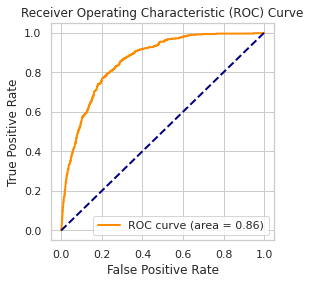

In [48]:
# Замените probabilities_results и y_test на ваши фактические значения
fpr, tpr, thresholds = roc_curve(y_test, probabilities_results)
roc_auc = auc(fpr, tpr)

# Строим ROC-кривую
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Модель эффективно справляется с задачей классификации объектов. Целевая метрика достигнута.

*Исследуем важность признаков*

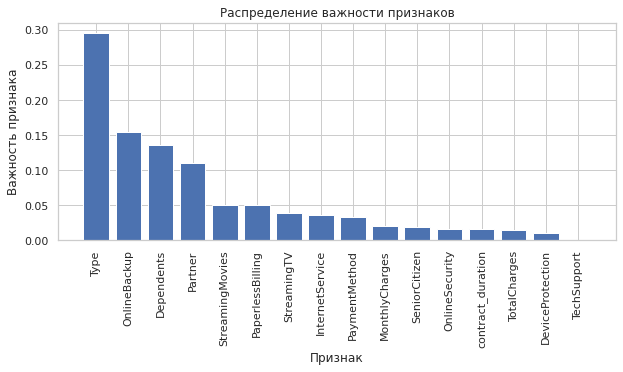

In [49]:
# Оценка важности признаков
feature_importance = grid_search_xgboost.best_estimator_.feature_importances_
sorted_idx = feature_importance.argsort()[::-1]
feature_names = X_test.columns  # Замените на ваш фактический список названий признаков

# Визуализация важности признаков
plt.figure(figsize=(10, 4))
plt.bar(range(len(feature_importance)), feature_importance[sorted_idx], align="center")
plt.xticks(range(len(feature_importance)), feature_names[sorted_idx], rotation=90)
plt.xlabel("Признак")
plt.ylabel("Важность признака")
plt.title("Распределение важности признаков")
plt.show()

*Из данного графика видно, что в большей сттепени на удержание клиентов, влияют такие факторы, как:* 
    
    1) Способ оплаты;
    2) Тип подключения;
    3) Техническая поддержка.
    
    
*Изучим также и матрицу ошибок:*

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      1294
           1       0.67      0.54      0.59       467

    accuracy                           0.81      1761
   macro avg       0.76      0.72      0.73      1761
weighted avg       0.80      0.81      0.80      1761



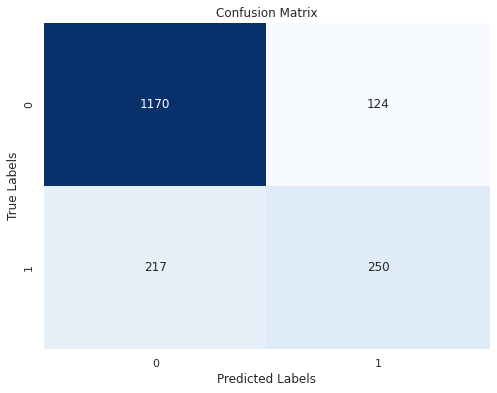

In [50]:
threshold = 0.5
y_pred = (probabilities_results > threshold).astype(int)

# Вычисление матрицы ошибок
conf_matrix = confusion_matrix(y_test, y_pred)

# Вычисление precision, recall и F1-меры
report = classification_report(y_test, y_pred)
print('Classification Report:\n', report)

# Визуализация матрицы ошибок с использованием seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



*Исходя из матрицы видно, что модель эффективно справляется с задачей классификации объектов.*
*В качестве резюмирующей оценки построим ещё одну удобную визуализацию:*

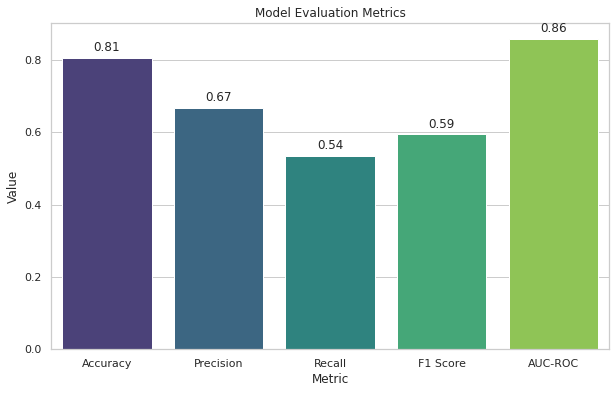

In [51]:
# Вычисление метрик
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, probabilities_results)

# Создание DataFrame для визуализации
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC'],
    'Value': [accuracy, precision, recall, f1, auc_roc]
})

# Визуализация с использованием seaborn
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Metric', y='Value', data=metrics_df, palette='viridis')
plt.title('Model Evaluation Metrics')

# Добавление подписей
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

## Вывод

С помощью моделирования на базе XGBoost. Были достигнуты следующие результаты:

    1. ROC-AUC 0.86, при требование 0.85.  
    2. Precision = 0.67 - неплохой результат: если мы предполагаем, что человек покинет организацию, то существует значительная вероятность, что этот человек действительно её покинет.
    3. Accuracy модели - 0.81. Можно сказать, что существует 80% вероятность, что модель правильно классифицирует пользователя.
    4. Recall: из всех реальных клиентов, кто покинет организацию модель идентифицирует 0.54.
    5. F1 не слишком высокая: Recall тянет её вниз. Но если нам потребуется немного повысить Recall ценой Precision, то мы сможем это сделать, понизив порог вероятности при предсказаниях.

# Итоговые выводы

Перед нами стояла задача: Создать модель на базе машинного обучения, которая бы позволил правильно идентифицировать пользователей, которые в скоре могут перестать быть клиентом целевой компании.

Для достижения этой цели, необходимо было:
    
    1) Подготовить и изучить данные;
    2) Подготовить данные для моделирования;
    3) Обучить разные модели и определить "лучшую";
    4) Протестировать модель.

В результате работы была создана модель на базе градиентного бустинга, которая достигла следующих результатов:
    
    1) ROC-AUC = 0.86
    2) Precision = 0.66
    3) Accuracy  = 0.80
    4) Recall = 0.55
    5) F1-мера составляет 0.60.
    
Эти показатели нам говорят о вполне эффективной и сбалансированной модели, которая может быть полезна для бизнеса.